## Practice: How to open/decode/pre-process HDF4 MODIS data?
--------
### Prerequisite
Did you read document and webpage below? These information help you to understand this notebook example

- User Guide for MODIS021KM (MUST READ Chapter.5)  
    [User Guide MODIS L1B: MOD021KM](https://mcst.gsfc.nasa.gov/content/l1b-documents)  
    

- Website to learn an example of hdf file operation especially targets MODIS product  
    [How to read a MODIS HDF4 file using python and pyhdf ?](https://www.science-emergence.com/Articles/How-to-read-a-MODIS-HDF-file-using-python-/)


------------
### Tasks: What skills you should learn from notebook
1. Open HDF4 file, and read SDS data
2. Scaling a compressed SDS interger data to a floating points calibrated radiance data (aka. decode)
3. Understand how to avoid invalid values
4. Leverage MOD35 product to select patches containig more than X % of clouds pixel

### Import necessary modules and functions

In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

from pyhdf.SD import SD, SDC

In [4]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
hdf_libdir='/home/tkurihana/clouds/src_analysis/lib_hdfs'

In [5]:
# this line helps you to use your own functinos in another directory
sys.path.insert(1,os.path.join(sys.path[0],hdf_libdir))

# we use below library later. Firstly, you should understand one line by one line.
# When you completely  understand the entire workload, read libraries below then use them.
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

### Download MODIS021KM for practice

Data1: Common data: Fill value but No calibration contamination & NO invalid pixel

In [ ]:
! wget https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2001/162/MOD021KM.A2001162.1635.061.2017173010442.hdf

Data2: Data with Fill value and Calibration contamination

In [ ]:
! wget https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2015/192/MOD021KM.A2015192.2215.061.2017321064853.hdf

Data3: Data with Fill value and Invalid contamination

In [ ]:
! wget https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/021/MOD021KM.A2017021.2145.061.2017312002131.hdf

Data4: Advanced. Report pixel value band-29. There were some horizontal lines with relatively higher values than other pixels

In [ ]:
! wget https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2007/005/MOD021KM.A2007005.0700.061.2017246010502.hdf

------------
### Open Data

In [6]:
filename = '/home/tkurihana/scratch-midway2/data/MOD02/strage_mod02/nc_16_np_500/MOD021KM.A2015192.2115.061.2017321070018.hdf'
hdf = SD(filename, SDC.READ)

In [8]:
# select item among contents of dataset
hdf_sds = hdf.select("EV_1KM_Emissive")

In [10]:
# Check hdf_sds's metadata
hdf_sds.attributes()

{'long_name': 'Earth View 1KM Emissive Bands Scaled Integers',
 'units': 'none',
 'valid_range': [0, 32767],
 '_FillValue': 65535,
 'band_names': '20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36',
 'radiance_scales': [6.262398528633639e-05,
  0.0031495101284235716,
  6.921597378095612e-05,
  7.910397835075855e-05,
  3.155614103889093e-05,
  5.639820665237494e-05,
  0.00011755729792639613,
  0.0001924497337313369,
  0.000532486941665411,
  0.0004063234373461455,
  0.0008400219958275557,
  0.000729697581846267,
  0.00026226387126371264,
  0.00020069582387804985,
  0.0001767082721926272,
  0.0001183385684271343],
 'radiance_offsets': [2730.58349609375,
  2730.58349609375,
  2730.58349609375,
  2730.58349609375,
  1077.44482421875,
  1560.3333740234375,
  2730.583251953125,
  2317.48828125,
  2730.58349609375,
  1560.333251953125,
  1577.3397216796875,
  1658.2213134765625,
  2501.297607421875,
  2501.297607421875,
  2501.2978515625,
  2501.2978515625],
 'radiance_units': 'Watts/m^2/microm

In [9]:
# get value as numpy array
hdf_array = hdf_sds.get()

In [7]:
# check contents
hdf.datasets()

{'Latitude': (('2*nscans:MODIS_SWATH_Type_L1B',
   '1KM_geo_dim:MODIS_SWATH_Type_L1B'),
  (406, 271),
  5,
  0),
 'Longitude': (('2*nscans:MODIS_SWATH_Type_L1B',
   '1KM_geo_dim:MODIS_SWATH_Type_L1B'),
  (406, 271),
  5,
  1),
 'EV_1KM_RefSB': (('Band_1KM_RefSB:MODIS_SWATH_Type_L1B',
   '10*nscans:MODIS_SWATH_Type_L1B',
   'Max_EV_frames:MODIS_SWATH_Type_L1B'),
  (15, 2030, 1354),
  23,
  2),
 'EV_1KM_RefSB_Uncert_Indexes': (('Band_1KM_RefSB:MODIS_SWATH_Type_L1B',
   '10*nscans:MODIS_SWATH_Type_L1B',
   'Max_EV_frames:MODIS_SWATH_Type_L1B'),
  (15, 2030, 1354),
  21,
  3),
 'EV_1KM_Emissive': (('Band_1KM_Emissive:MODIS_SWATH_Type_L1B',
   '10*nscans:MODIS_SWATH_Type_L1B',
   'Max_EV_frames:MODIS_SWATH_Type_L1B'),
  (16, 2030, 1354),
  23,
  4),
 'EV_1KM_Emissive_Uncert_Indexes': (('Band_1KM_Emissive:MODIS_SWATH_Type_L1B',
   '10*nscans:MODIS_SWATH_Type_L1B',
   'Max_EV_frames:MODIS_SWATH_Type_L1B'),
  (16, 2030, 1354),
  21,
  5),
 'EV_250_Aggr1km_RefSB': (('Band_250M:MODIS_SWATH_Type_

### Just plot SI/SDS data (before decoded)
This plot shows "before" decoding SDS data properly. So, DO NOT USE THIS SDS DATA IF YOU SCIENTIFICALLY ANALYZE.
BUT, eventually, you should look this value to detect "invalid values" which are valued 655XX by NASA.

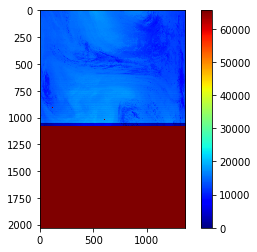

In [13]:
plt.imshow(hdf_array[7], cmap='jet')
plt.colorbar()

-----------
## Comments

#### Calibration contamination
[MODIS Events PV ECAL](https://mcst.gsfc.nasa.gov/modis-events-categories/routine-calibrations/pv-ecal?event_date%5Bvalue%5D%5Byear%5D=&modis_mission=61)

#### Fill value and Invalid datas
![invalid](./sample_fig/invalid.PNG)

#### Easy way to avoid these invalid value
Only process SI data, which ranges from 0 to 32767, and scale them by the decode rule (explain afterwords).

--------
### Decode
#### Algorithm how NASA compressed 32-bit floating point data into SI data. 


![scaling](./sample_fig/scaling.PNG)  

#### Decoding equation you should apply when decoding process.  


![decode](./sample_fig/decode_rule.PNG)  

--------------

In [15]:
## decoding process
"""When you want to check how each line affects output, just comment off and process steps. 
   Initially, all process are NOT commented out. 
"""

### converet integer array to float array
hdf_array = hdf_array.astype(np.float64)

### Get FillValue index
nan_idx = np.where(hdf_array == hdf_sds.attributes()["_FillValue"])
hdf_array[nan_idx] = np.nan

### Get rid of invald index 
invalid_idx = np.where( hdf_array > 32767 )
hdf_array[invalid_idx] = np.nan

###  offset process
offset = hdf_sds.attributes()['radiance_offsets']
offset_array = np.zeros(hdf_array.shape)
offset_ones  = np.ones(hdf_array.shape)
for iband in range(len(offset)):
    offset_array[iband, :,:] = hdf_array[iband, :,:] - offset[iband]*offset_ones[iband,:,:]

    
### scaling process
scales = hdf_sds.attributes()['radiance_scales']
scales_array = np.zeros(hdf_array.shape)
for iband in range(len(scales)):
    scales_array[iband,:,:] = scales[iband]*offset_array[iband,:,:]

#### Plot decoded data!!

In [23]:
# make band list for figure's label

band_names = hdf_sds.attributes()['band_names']
bands = []
band_names.strip("'")
bands = [i for i in band_names.split(",")]

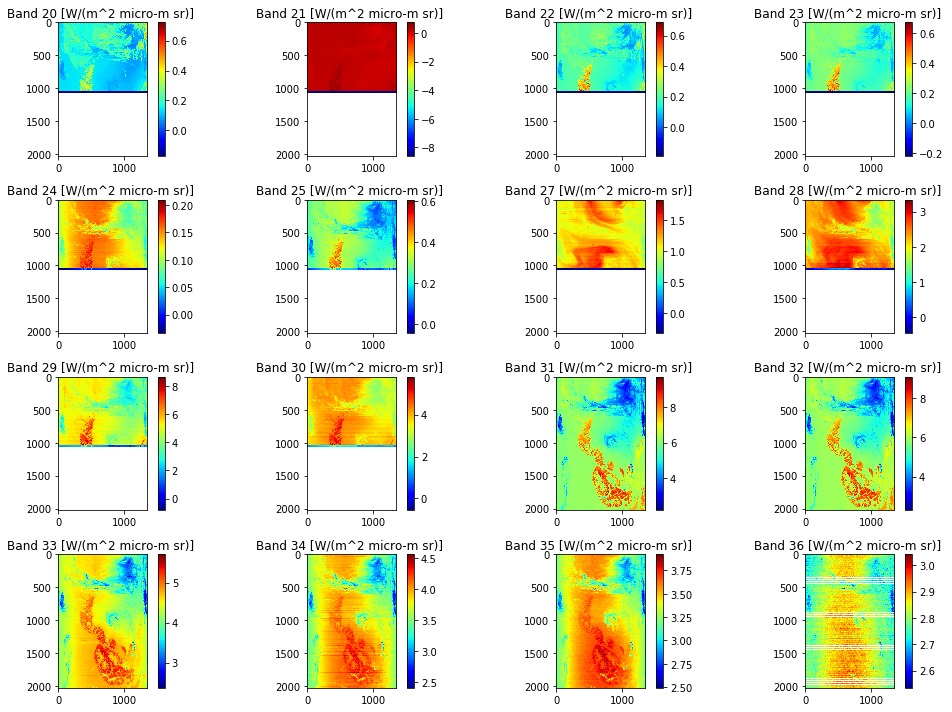

In [27]:
fig = plt.figure(figsize=(14,10))

for i in range(len(scales_array)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(scales_array[i], cmap='jet')
    ax.set_title("Band %s [W/(m^2 micro-m sr)] " % bands[i])
    plt.colorbar()
fig.tight_layout()
plt.show()

-----------------
### Assignments
1. Decode other images and plot them
2. Compare values by plotting with-without FillValue and invalid value after decoding
3. Plot histogram of number of invalid values by using modules/examples above
4. Challenge advance dataset
* User can of course get information of calibration contamination. But the proecessis out of this notebook.

If anything you have questions, feel free to ask Takuya. This data processing is the most imortant part of this research. 
Accurate processing is required.  